In [1]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.6 MB/s 
     |████████████████████████████████| 9.8 MB 42.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import numpy as np
from fbprophet import Prophet
import pandas as pd
#
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
#
import seaborn as sns
import matplotlib.pyplot as plt
#
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots
#
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/iAnalyst/AssignmentData.csv',parse_dates =['datetime','date'])
df.drop(axis=1, columns=["Unnamed: 0","date"],inplace=True)
df = df.set_index('datetime')

In [5]:
df= df.dropna() 

In [6]:
print(df.head())
print(df.shape)

                          load  apparent_temperature  ...  wind_speed  cloud_cover
datetime                                              ...                         
2018-01-01 00:00:00  803.22270              10.45800  ...         0.0          0.0
2018-01-01 00:15:00  774.89523              10.32675  ...         0.0          0.0
2018-01-01 00:30:00  731.46927              10.19550  ...         0.0          0.0
2018-01-01 00:45:00  713.93870              10.06425  ...         0.0          0.0
2018-01-01 01:00:00  699.23007               9.93300  ...         0.0          0.0

[5 rows x 7 columns]
(101952, 7)


In [7]:
##Plot your data

In [8]:
df.columns

Index(['load', 'apparent_temperature', 'temperature', 'humidity', 'dew_point',
       'wind_speed', 'cloud_cover'],
      dtype='object')

In [9]:
df.isnull().sum()

load                    0
apparent_temperature    0
temperature             0
humidity                0
dew_point               0
wind_speed              0
cloud_cover             0
dtype: int64

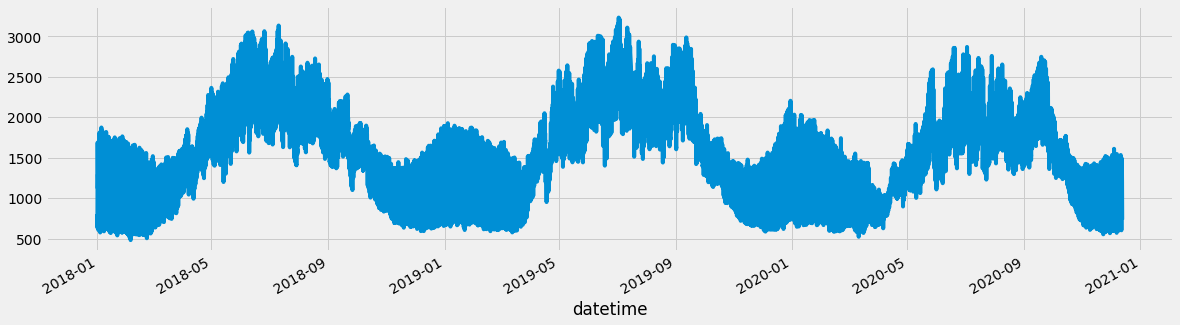

In [10]:
df['load'].plot(figsize=(18,5))  #try all the columns

In [11]:
##Check for stationarity using dickey fuller test.
# this test returns certain statistical parameters which can be used to judge if a dataset is stationary or  not.

In [12]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')   #adfuller returns array of values
    print("1. ADF : ", dftest[0])
    print("2. P-value : ", dftest[1])
    print("3. Num of lags : ", dftest[2])
    print("4. Num of observations used for ADF Regression and Critical Values Calculation : ", dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t", key, ":", val)

In [13]:
ad_test(df['load'])

1. ADF :  -6.15577038957692
2. P-value :  7.375145269448146e-08
3. Num of lags :  68
4. Num of observations used for ADF Regression and Critical Values Calculation :  101883
5. Critical Values : 
	 1% : -3.430414186024805
	 5% : -2.861568369223142
	 10% : -2.5667850999437674


In [14]:
## We see that the p-value is very small. This means that the dataset is stationary and we can proceed 

#Figure out order of ARIMA model.


In [15]:
from pmdarima import auto_arima
#Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [16]:
stepwise_fit = auto_arima(df['load'], trace=True, suppress_warnings= True)  #trace will print out as its iterating to each step
#auto arima will carry out all the orders like 1,0,0  0,1,0  0,1,2  etc  and for every model it will assign a score which is called AIC.
#Goal is to minimize the AIC.
#ARIMA order is named p,d,q. values are named in this order

stepwise_fit.summary()

#It looks for the minimum AIC score.  #takes 10 mins to run on GPU

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=118.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=986762.801, Time=2.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=911802.874, Time=3.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=947902.755, Time=19.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=986760.801, Time=1.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=899747.835, Time=4.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=898606.054, Time=5.72 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=898585.463, Time=7.35 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=898101.582, Time=8.81 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=173.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=156.15 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=898099.582, Time=3.62 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=898583.463, Time=3.11 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=73.22 sec
 ARIMA(4,1,1)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               101952
Model:               SARIMAX(5, 1, 0)   Log Likelihood             -449043.791
Date:                Fri, 07 Jan 2022   AIC                         898099.582
Time:                        07:22:43   BIC                         898156.775
Sample:                             0   HQIC                        898116.924
                             - 101952                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4458      0.001    462.602      0.000       0.444       0.448
ar.L2          0.2952      0.001    232.988      0.000       0.293       0.298
ar.L3          0.1321      0.002     66.060      0.000       0.128       0.136
ar.L4          0.0159      0.003      6.358      0.000       0.011       0.021
ar.L5         -0.0690      0.002    -28.926      0.000      -0.074      -0.064
sigma2       391.9552      0.366   1069.731      0.000     391.237     392.673
===================================================================================
Ljung-Box (L1) (Q):                   2.72   Jarque-Bera (JB):           8747584.25
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
#We see the best model as ARIMA with order (5,1,0)

In [26]:
#pip install git+https://github.com/statsmodels/statsmodels  #takes 1 hour on TPU

  Cloning https://github.com/statsmodels/statsmodels.git to /tmp/pip-req-build-5pnaw260
  Running command git clone -q https://github.com/statsmodels/statsmodels.git /tmp/pip-req-build-5pnaw260
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user


In [ ]:
#pip uninstall statsmodels && pip install statsmodels --pgrade

In [19]:
!pip install statsmodels
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.arima.model as stats

In [20]:
#Splitting the data into training and testing
#from sklearn.model_selection import train_test_split

In [21]:
print(df.shape)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)  #not using 

train= df.iloc[:-20000]
test= df.iloc[-20000:]
print(train.shape, test.shape)

(101952, 7)
(81952, 7) (20000, 7)


In [22]:
#Training the model

In [23]:
model = stats.ARIMA(train['load'], order=(5,1,0), trend="t")
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   load   No. Observations:                81952
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -364231.248
Date:                Fri, 07 Jan 2022   AIC                         728476.497
Time:                        07:23:59   BIC                         728541.694
Sample:                             0   HQIC                        728496.461
                              - 81952                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0078      0.403      0.019      0.985      -0.781       0.797
ar.L1          0.4293      0.001    393.953      0.000       0.427       0.431
ar.L2          0.2913      0.001    205.700      0.000       0.289       0.294
ar.L3          0.1372      0.002     62.109      0.000       0.133       0.142
ar.L4          0.0217      0.003      7.610      0.000       0.016       0.027
ar.L5         -0.0639      0.003    -23.294      0.000      -0.069      -0.059
sigma2       424.5976      0.437    971.485      0.000     423.741     425.454
===================================================================================
Ljung-Box (L1) (Q):                   1.77   Jarque-Bera (JB):           7621831.64
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        50.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
#Making predictions on test

In [25]:
start= len(train)
end= len(train)+len(test)-1
pred= model.predict(start= start, end= end, typ= 'levels')
#print(pred)

pred.index= df.index[start:end+1]  #index was not date before. now converted to date
print(pred)

datetime
2020-05-15 16:00:00    1440.530135
2020-05-15 16:15:00    1436.472461
2020-05-15 16:30:00    1432.682104
2020-05-15 16:45:00    1429.464919
2020-05-15 17:00:00    1426.719870
                          ...     
2020-12-12 22:45:00    1564.289511
2020-12-12 23:00:00    1564.297330
2020-12-12 23:15:00    1564.305149
2020-12-12 23:30:00    1564.312968
2020-12-12 23:45:00    1564.320788
Name: predicted_mean, Length: 20000, dtype: float64


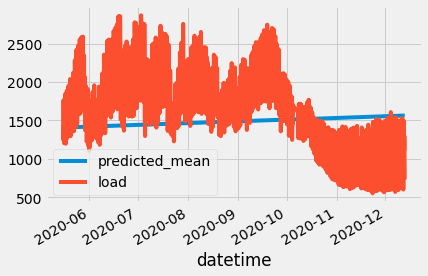

In [26]:
pred.plot(legend= True)
test['load'].plot(legend=True)

In [27]:
test['load'].mean()

1647.1741578280073

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test['load']))
print(rmse)

523.0330883902369


In [29]:
#RMSE very high. Mean of the dataset is 1647 and the avg error is 522 which is not good and it makes a bad model.

In [30]:
#Now predicting on the future dates

In [31]:
#model2= ARIMA(df['load'], order= (5,1,0))
model2 = stats.ARIMA(df['load'], order=(5,1,0), trend="t")
model2= model2.fit()
df.tail()

,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
datetime,,,,,,,
2020-12-12 22:45:00,858.50,17.79750,17.79750,0.756000,12.4005,1.950375,0.16275
2020-12-12 23:00:00,832.24,17.66100,17.66100,0.756000,12.2640,2.047500,0.14700
2020-12-12 23:15:00,804.97,17.46675,17.46675,0.758625,12.1275,2.144625,0.11550
2020-12-12 23:30:00,763.56,17.27250,17.27250,0.761250,11.9910,2.241750,0.08400
2020-12-12 23:45:00,734.27,17.07825,17.07825,0.763875,11.8545,2.338875,0.05250


In [32]:
index_future_dates= pd.date_range(start='2020-12-14 00:00:00', end='2020-12-14 23:45:00', freq='0.25H')
#print(index_future_dates)
pred= model2.predict(start= len(df), end= len(df)+95, typ='levels').rename('ARIMA Predictions')   #enter the no. of days correctly in 'end= len(df) + no. of days)'
#print(comp_pred)
pred.index= index_future_dates
#print(comp_pred)
print(pred)

2020-12-14 00:00:00    707.614635
2020-12-14 00:15:00    682.992092
2020-12-14 00:30:00    661.498691
2020-12-14 00:45:00    643.516444
2020-12-14 01:00:00    627.497965
                          ...    
2020-12-14 22:45:00    525.071959
2020-12-14 23:00:00    525.071236
2020-12-14 23:15:00    525.070520
2020-12-14 23:30:00    525.069809
2020-12-14 23:45:00    525.069103
Freq: 15T, Name: ARIMA Predictions, Length: 96, dtype: float64


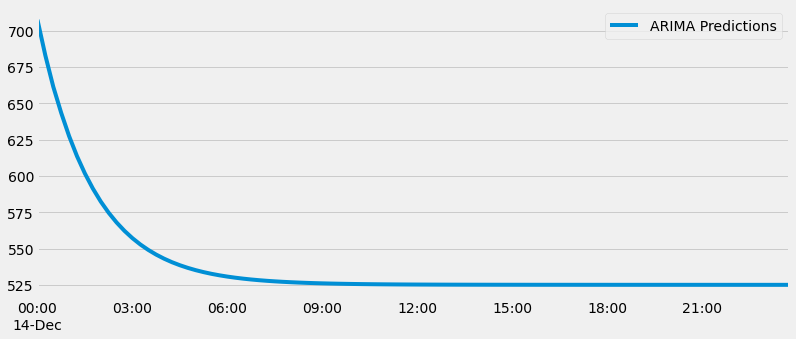

In [33]:
pred.plot(figsize=(12,5), legend=True)

# Task2: Taking test data as the ones with null values

In [37]:
df1= pd.read_csv('/content/drive/MyDrive/iAnalyst/AssignmentData.csv',parse_dates =['datetime','date'])

In [38]:
print(df1.isnull().sum())
df1 = df1.set_index('datetime')

Unnamed: 0                 0
datetime                   0
load                    1632
apparent_temperature       0
temperature                0
humidity                   0
dew_point                  0
wind_speed                 0
cloud_cover                0
date                       0
dtype: int64


In [39]:
todrop= ['Unnamed: 0','date']
df1= df1.drop(todrop, axis=1, inplace=False)
print(df1)

                          load  apparent_temperature  ...  wind_speed  cloud_cover
datetime                                              ...                         
2018-01-01 00:00:00  803.22270             10.458000  ...      0.0000       0.0000
2018-01-01 00:15:00  774.89523             10.326750  ...      0.0000       0.0000
2018-01-01 00:30:00  731.46927             10.195500  ...      0.0000       0.0000
2018-01-01 00:45:00  713.93870             10.064250  ...      0.0000       0.0000
2018-01-01 01:00:00  699.23007              9.933000  ...      0.0000       0.0000
...                        ...                   ...  ...         ...          ...
2020-12-14 22:45:00        NaN             12.450375  ...      1.9110       0.0000
2020-12-14 23:00:00        NaN             12.285000  ...      1.8795       0.0000
2020-12-14 23:15:00        NaN             13.650000  ...      2.4675       0.8925
2020-12-14 23:30:00        NaN             13.650000  ...      2.4150       0.8925
2020

In [40]:
df1.head()

,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
datetime,,,,,,,
2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0
2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0
2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0
2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0
2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0


In [41]:
#getting null values and create dataframe 
test = df1[df1['load'].isnull()]
test.drop(axis=1, columns=["load"],inplace=True)
print(test.shape)
test.head()

(1632, 6)


,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
datetime,,,,,,
2019-05-16 00:00:00,31.458000,31.458000,0.441000,16.56900,0.1365,0.462
2019-05-16 00:15:00,31.371375,31.371375,0.443625,16.55325,0.1680,0.462
2019-05-16 00:30:00,31.284750,31.284750,0.446250,16.53750,0.1995,0.462
2019-05-16 00:45:00,31.198125,31.198125,0.448875,16.52175,0.2310,0.462
2019-05-16 01:00:00,31.111500,31.111500,0.451500,16.50600,0.2625,0.462


In [42]:
train = df1.dropna()
print(train.shape)
train.head()

(101952, 7)


,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
datetime,,,,,,,
2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0
2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0
2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0
2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0
2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0


In [43]:
stepwise_fit = auto_arima(train['load'], trace=True, suppress_warnings= True)  #trace will print out as its iterating to each step
#auto arima will carry out all the orders like 1,0,0  0,1,0  0,1,2  etc  and for every model it will assign a score which is called AIC.
#Goal is to minimize the AIC.
#ARIMA order is named p,d,q. values are named in this order

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=118.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=986762.801, Time=2.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=911802.874, Time=2.89 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=947902.755, Time=17.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=986760.801, Time=1.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=899747.835, Time=3.92 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=898606.054, Time=5.48 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=898585.463, Time=7.00 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=898101.582, Time=8.83 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=170.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=151.16 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=898099.582, Time=3.72 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=898583.463, Time=3.21 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=72.08 sec
 ARIMA(4,1,1)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               101952
Model:               SARIMAX(5, 1, 0)   Log Likelihood             -449043.791
Date:                Fri, 07 Jan 2022   AIC                         898099.582
Time:                        07:37:18   BIC                         898156.775
Sample:                             0   HQIC                        898116.924
                             - 101952                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4458      0.001    462.602      0.000       0.444       0.448
ar.L2          0.2952      0.001    232.988      0.000       0.293       0.298
ar.L3          0.1321      0.002     66.060      0.000       0.128       0.136
ar.L4          0.0159      0.003      6.358      0.000       0.011       0.021
ar.L5         -0.0690      0.002    -28.926      0.000      -0.074      -0.064
sigma2       391.9552      0.366   1069.731      0.000     391.237     392.673
===================================================================================
Ljung-Box (L1) (Q):                   2.72   Jarque-Bera (JB):           8747584.25
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
model = stats.ARIMA(train['load'], order=(5,1,0), trend="t")
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   load   No. Observations:               101952
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -449043.791
Date:                Fri, 07 Jan 2022   AIC                         898101.582
Time:                        07:37:31   BIC                         898168.308
Sample:                             0   HQIC                        898121.814
                             - 101952                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0007      0.354     -0.002      0.998      -0.695       0.693
ar.L1          0.4458      0.001    461.138      0.000       0.444       0.448
ar.L2          0.2952      0.001    232.440      0.000       0.293       0.298
ar.L3          0.1321      0.002     66.060      0.000       0.128       0.136
ar.L4          0.0159      0.003      6.350      0.000       0.011       0.021
ar.L5         -0.0690      0.002    -28.750      0.000      -0.074      -0.064
sigma2       391.9552      0.368   1064.566      0.000     391.234     392.677
===================================================================================
Ljung-Box (L1) (Q):                   2.72   Jarque-Bera (JB):           8747584.26
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

datetime
2018-01-01 00:00:00     -0.000676
2018-01-01 00:15:00    803.763614
2018-01-01 00:30:00    754.578606
2018-01-01 00:45:00    701.174194
2018-01-01 01:00:00    690.836323
                          ...    
2020-12-12 22:45:00    871.834893
2020-12-12 23:00:00    828.962824
2020-12-12 23:15:00    806.849679
2020-12-12 23:30:00    780.580330
2020-12-12 23:45:00    735.545594
Name: predicted_mean, Length: 101952, dtype: float64


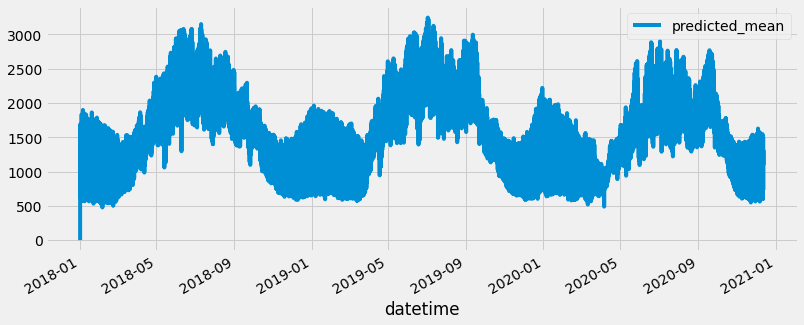

In [45]:
pred= model.predict(data= test, typ= 'levels')
#print(pred)

#pred.index= df.index[start:end+1]  #index was not date before. now converted to date
print(pred)
pred.plot(figsize=(12,5), legend=True)

# Visualize Training Data for the given time span

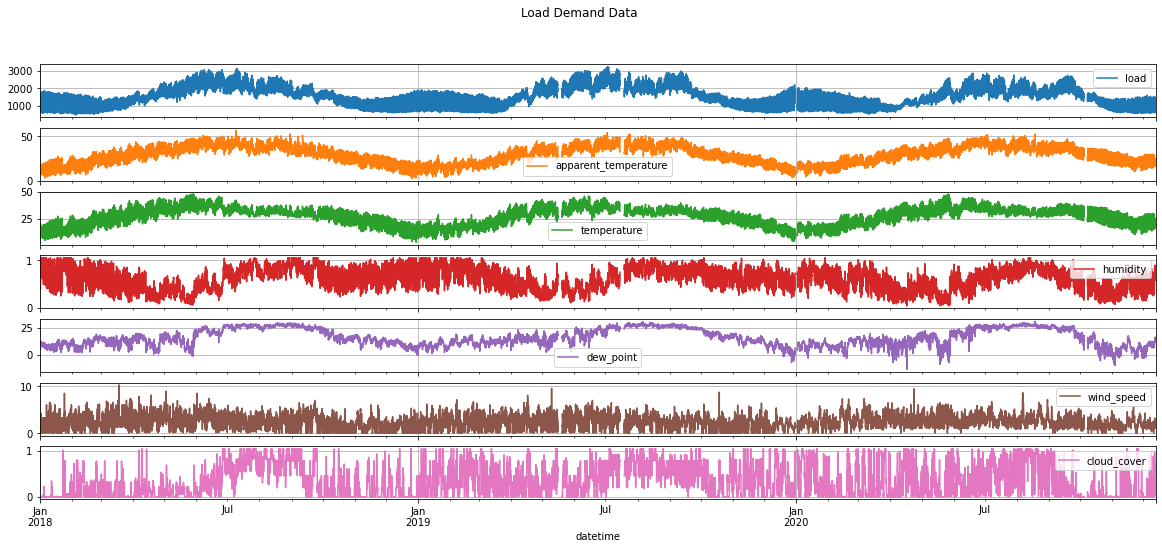

In [ ]:
#Visualize Training Data for the given time span
#train.resample('15min').mean().plot(grid=True,title='Load Demand Data',figsize=(20,8),subplots=True)
#plt.show()

Automate Time Series Forecasting using Auto-TS
Auto TimeSeries
image.png

Auto-TS is an open-source Python library with time series forecasting implementation.

It can train multiple time series forecasting models including ARIMA, SARIMAX, FB Prophet, VAR, etc, in just one line of Python code, and then choose the best one out of it for predictions.

Some of the features of Auto-TS libraries are:
Finds the optimal time series forecasting model using genetic programming optimization.
Trains naive, statistical, machine learning, and deep learning models, with all possible hyperparameter configurations, and cross-validation.
Performs data transformations to handle messy data by learning optimal NaN imputation and outlier removal.
Choice of the combination of metrics for model selection.

In [ ]:
#!pip install auto-ts

In [ ]:
#!pip3 install auto-ts

In [ ]:
#!pip install auto_ts

In [ ]:
#!pip install auto-ts --upgrade

In [ ]:
#!pip install dask[complete]

In [ ]:
#!pip install dask_xgboost

In [ ]:
#!pip install dask distributed --upgrade